In [39]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from typing import List, Dict
import time

# Compiling block

In [40]:
class ClogParser:
    def __init__(self, exe_path: str, args: List[str], makefile_dir: str = None):
        self.exe_path = exe_path
        self.args = args
        self.makefile_dir = makefile_dir or os.path.dirname(exe_path)

    def compile(self) -> None:
        print("🔧 Compiling with make...")
        start = time.time()
        result = subprocess.run(["make","pull"], cwd=self.makefile_dir, capture_output=True, text=True)
        end = time.time()
        if result.returncode != 0:
            print("❌ Make failed!\n", result.stderr)
            raise RuntimeError("Compilation failed.")
        print(f"✅ Compilation successful for {end - start}s.")

    def run(self):
        print("🔧 Running it...")
        start = time.time()
        result = subprocess.run([self.exe_path] + self.args, capture_output=True, text=True)
        end = time.time()
        if result.stderr:
            print("Execution stderr:\n", result.stderr)
        print(f"✅ Done running for {end - start}s.")
        return result.stderr, result.stdout

    def parse_monitoring_lines(self, logs: str):
        records_time = []
        records_fp = []
        all_added_set = set()

        logs = logs.strip().split('\n')
        # First pass: collect all num_added from all fp_logs
        for line in logs:
            if 'fp_log=all_1' in line:
                continue
            fp_raw = re.search(r'fp_log=([\(\)0-9,]+)', line)
            if fp_raw:
                fp_sets = re.findall(r'\((\d+),(\d+),(\d+)\)', fp_raw.group(1))
                for _, added, _ in fp_sets:
                    all_added_set.add(int(added))

        sorted_added = sorted(all_added_set)  # ensure consistency

        # Second pass: process logs
        for line in logs:
            algo_match = re.search(r'algo=(\S+)', line)
            algo = algo_match.group(1) if algo_match else "Binary"
            filter_name = re.search(r'filter=(\S+)', line).group(1)

            insert_time_raw = re.search(r'avg_insert_time=([\d\.:]+)', line).group(1)
            test_time_raw = re.search(r'avg_test_time=([\d\.:]+)', line).group(1)
            
            insert_parts = list(map(float, insert_time_raw.split(':')))
            test_parts = list(map(float, test_time_raw.split(':')))

            insert_time = insert_parts[0]
            for p in insert_parts[1:]:
                insert_time /= p
            test_time = test_parts[0]
            for p in test_parts[1:]:
                test_time /= p

            records_time.append({
                "algo": algo,
                "filter": filter_name,
                "avg_insert_time_us": insert_time * 1e6,
                "avg_test_time_us": test_time * 1e6,
            })

            if 'fp_log=all_1' in line:
                for added in sorted_added:
                    records_fp.append({
                        "algo": algo,
                        "filter": filter_name,
                        "num_fp": 0,
                        "num_added": added,
                        "num_tested": 1,
                        "fp_rate": 0.0
                    })
            else:
                fp_raw = re.search(r'fp_log=([\(\)0-9,]+)', line).group(1)
                fp_sets = re.findall(r'\((\d+),(\d+),(\d+)\)', fp_raw)
                for fp, added, tested in fp_sets:
                    records_fp.append({
                        "algo": algo,
                        "filter": filter_name,
                        "num_fp": int(fp),
                        "num_added": int(added),
                        "num_tested": int(tested),
                        "fp_rate": int(fp) / int(tested)
                    })

        df_time = pd.DataFrame(records_time)
        df_fp = pd.DataFrame(records_fp)
        return df_time, df_fp


In [41]:
exe = "D:/Desktop/csbf/main.exe"
args = []
make_dir = "D:/Desktop/csbf"  # your Makefile directory

parser = ClogParser(exe_path=exe, args=args, makefile_dir=make_dir)
parser.compile()
monitors, logs = parser.run()

🔧 Compiling with make...
✅ Compilation successful for 5.978643178939819s.
🔧 Running it...
Execution stderr:
 [MONITOR] algo=murmur3_128 avg_insert_time=1.123395:600000 avg_test_time=47.416671:1000000:10 filter=OHBF fp_log=(7160,60000,1000000)(13470,120000,1000000)(18670,180000,1000000)(22896,240000,1000000)(26406,300000,1000000)(28802,360000,1000000)(30527,420000,1000000)(31263,480000,1000000)(31231,540000,1000000)(30173,600000,1000000) id=1747790037093 memory=7760935.000000 scheme=kir-mitz 
[MONITOR] algo=sha256 avg_insert_time=1.010574:600000 avg_test_time=59.289450:1000000:10 filter=OHBF fp_log=(593567,60000,1000000)(556855,120000,1000000)(520028,180000,1000000)(483086,240000,1000000)(445988,300000,1000000)(408766,360000,1000000)(371413,420000,1000000)(333864,480000,1000000)(296130,540000,1000000)(258434,600000,1000000) id=1747790056156 memory=7760935.000000 scheme=kir-mitz 
[MONITOR] algo=murmur3_128 avg_insert_time=1.585463:600000 avg_test_time=78.038760:1000000:10 filter=DelBF fp

In [42]:
df_time, df_fp = parser.parse_monitoring_lines(monitors)
# df.loc[66:70, 'Filter'] = 'MergableCBF'
# df.loc[46:65, 'Filter'] = 'MergeableFilter'
    
df_time.head()
df_fp.head()

,algo,filter,num_fp,num_added,num_tested,fp_rate
0,murmur3_128,OHBF,7160,60000,1000000,0.007160
1,murmur3_128,OHBF,13470,120000,1000000,0.013470
2,murmur3_128,OHBF,18670,180000,1000000,0.018670
3,murmur3_128,OHBF,22896,240000,1000000,0.022896
4,murmur3_128,OHBF,26406,300000,1000000,0.026406


# Visualization block

In [43]:
def plot_avg_times(df_time):
    unique_algos = df_time["algo"].unique()
    
    for algo in unique_algos:
        if algo == "Binary":
            continue

        # 📊 Include both current algo and Binary
        df_sub = df_time[df_time["algo"].isin([algo, "Binary"])].copy()
        df_sub["label"] = df_sub["filter"]
        
        x = range(len(df_sub))
        width = 0.35

        fig, ax = plt.subplots(figsize=(10, 5))
        bars_insert = ax.bar([i - width/2 for i in x], df_sub["avg_insert_time_us"], width, label='Insert Time (μs)')
        bars_test = ax.bar([i + width/2 for i in x], df_sub["avg_test_time_us"], width, label='Test Time (μs)')

        # 📐 Dynamic y-axis padding
        max_height = max(
            max((bar.get_height() for bar in bars_insert), default=0),
            max((bar.get_height() for bar in bars_test), default=0)
        )
        ax.set_ylim(top=max_height * 2 if max_height > 0 else 1)

        ax.bar_label(bars_insert, fmt="%.4f", padding=3)
        ax.bar_label(bars_test, fmt="%.4f", padding=3)

        ax.set_ylabel('Time (μs)')
        ax.set_title(f'Average Insert/Test Time per entry by Filters of Hash Algorithm = {algo}')
        ax.set_xticks(list(x))
        ax.set_xticklabels(df_sub["label"], ha='center')
        ax.legend()
        plt.tight_layout()
        plt.show()


def plot_fp_chart(df_fp):
    for algo in df_fp['algo'].unique():
        if algo == 'Binary':
            continue

        df_algo = df_fp[(df_fp['algo'] == algo) | (df_fp['algo'] == 'Binary')]
        fig, ax1 = plt.subplots(figsize=(10, 5))
        # ax2 = ax1.twinx()

        max_num_fp = 0
        max_fp_rate = 0

        for filter_name in df_algo['filter'].unique():
            df_filter = df_algo[df_algo['filter'] == filter_name]
            x = df_filter['num_added'].values
            y_fp = df_filter['num_fp'].values
            y_rate = df_filter['fp_rate'].values

            # 📈 Line chart for num_fp
            line, = ax1.plot(x, y_fp, marker='.', label=f'{filter_name}')

            # ✍️ Annotate only a few selected points
            step = max(1, len(x) // 3)  
            for i in range(0, len(x), step):
                ax1.annotate(f"{y_fp[i]}", (x[i], y_fp[i]), textcoords="offset points", xytext=(0, 8), ha='center', fontsize=8, color=line.get_color())

            # 📊 Bar chart for fp_rate
            # bars = ax2.bar(x, y_rate, width=20000, alpha=0.3, label=f'{filter_name}')

            max_num_fp = max(max_num_fp, max(y_fp))
            max_fp_rate = max(max_fp_rate, max(y_rate))

        # 🧭 Axis settings
        ax1.set_ylim(top=max_num_fp * 1.2 if max_num_fp > 0 else 1)  # 20% margin
        # ax2.set_ylim(top=max_fp_rate * 1.2 if max_fp_rate > 0 else 1)

        ax1.set_xlabel('Num Added')
        ax1.set_ylabel('False Positives', color='tab:blue')
        # ax2.set_ylabel('FP Rate', color='tab:orange')
        # plt.title(f"FP and FP Rate for Hash Algorithm over the filters: {algo}")
        plt.title(f"Number of False positives over the Filters of Hash Algorithm = {algo}")
        plt.tight_layout()
        plt.legend(loc='center right')
        plt.show()


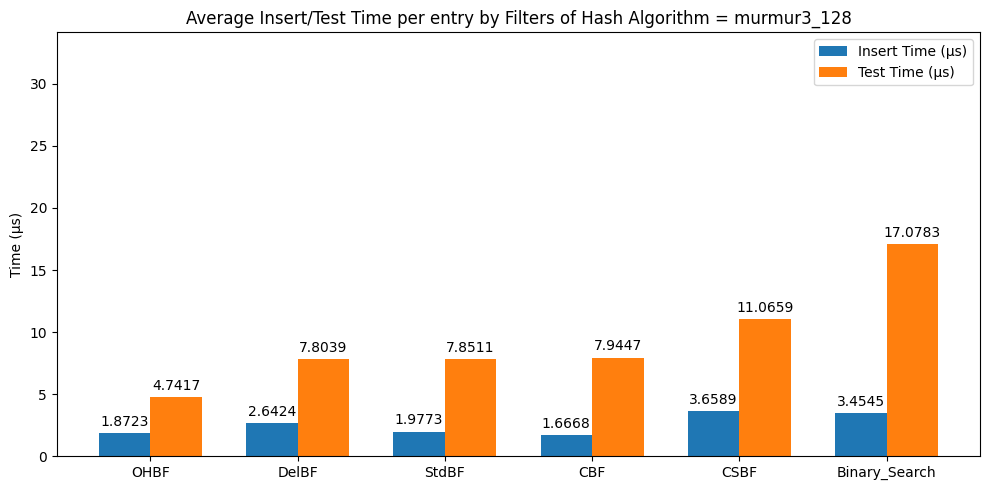

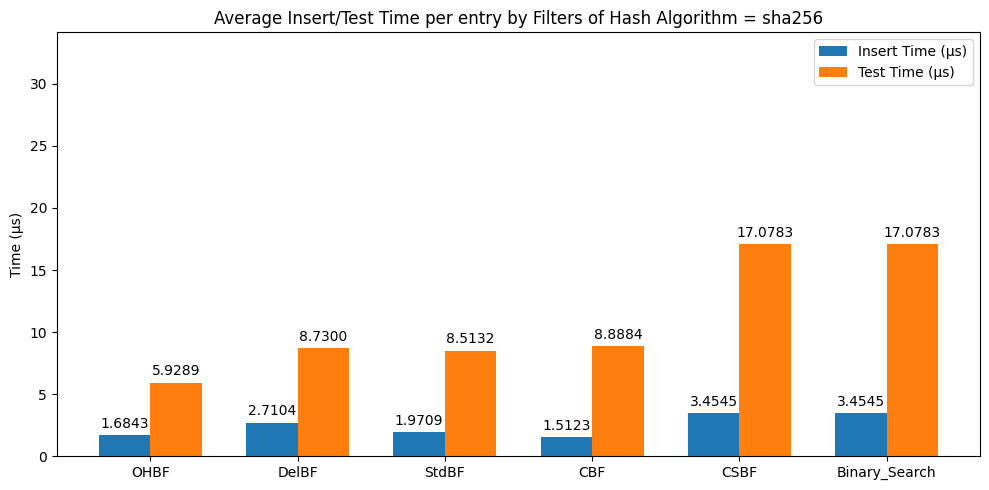

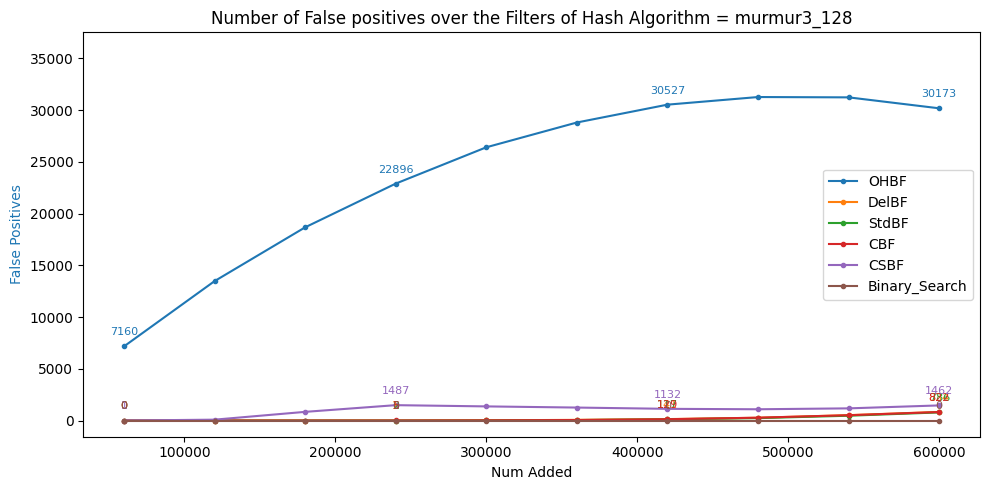

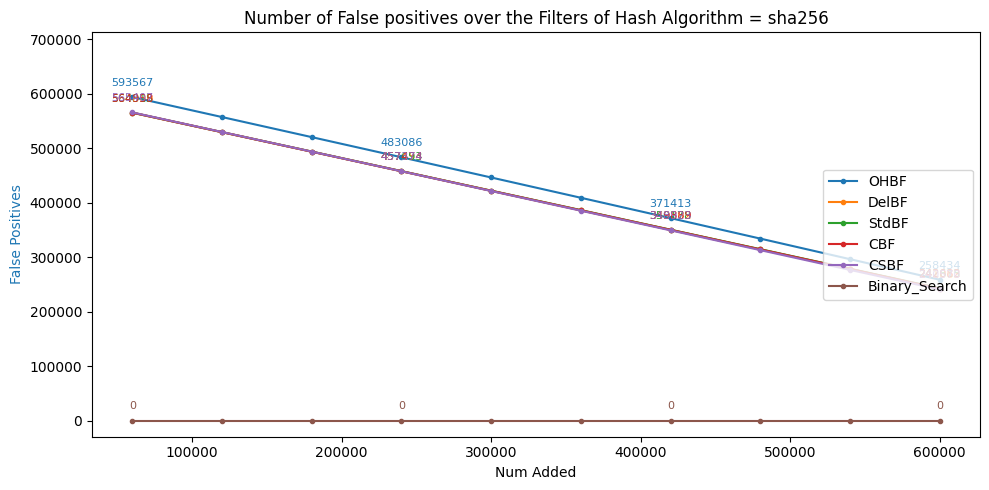

In [44]:
plot_avg_times(df_time)
plot_fp_chart(df_fp)

# Bus UC

### Time

In [45]:
# bus_targets = [
#     "OHBF",
#     "DelBF",
#     "StdBF",
#     "CBF",
#     "CSBF",
#     "Binary",
# ]
# visualizer = PerformanceVisualizer(df,'bus')
# visualizer.time_analysis_plot(bus_targets)

# ### Accuracy 
# visualizer.analyze_accuracy_plot(bus_targets)

# ### Memory
# visualizer.analyze_memory_plot(bus_targets)

# Bank UC

In [46]:
# bank_targets = ["MergedFilter.DelBF", "MergedFilter.StdBF", "MergedFilter.CBF", "MergedFilter.OHBF", "MergCBF", "Binary"] 
# visualizer = PerformanceVisualizer(df,'bank')
# visualizer.time_analysis_plot(bank_targets)

# ### Accuracy
# visualizer.analyze_accuracy_plot(bank_targets)

# ### Memory
# visualizer.analyze_memory_plot(bank_targets)